# Previsão de renda

## Etapa 1 CRISP - DM: Entendimento do negócio

Prever a renda dos clientes com base em diversas características, como gênero, posse de veículo, posse de imóvel, número de filhos, tipo de renda, nível de educação, estado civil, tipo de residência, idade, tempo de emprego e número de residentes no domicílio.


## Etapa 2 Crisp-DM: Entendimento dos dados
A segunda etapa é o entendimento dos dados. Foram fornecidas 14 variáveis mais a variável resposta (em negrito na tabela). O significado de cada uma dessas variáveis se encontra na tabela.

Dicionário de dados Os dados estão dispostos em uma tabela com uma linha para cada cliente, e uma coluna para cada variável armazenando as características desses clientes. Colocamos uma cópia o dicionário de dados (explicação dessas variáveis) abaixo neste notebook:</span>


### Dicionário de dados

<span style="color:red"></span>


| Variável                | Descrição                                           | Tipo         |
| ----------------------- |:---------------------------------------------------:| ------------:|
| data_ref                |  Data de referência                                 | texto        |
| id_cliente              |  Código cliente                                     | inteiro      |
| sexo                    |  Sexo                                               | M/F          |
| posse_de_veiculo        |  Possui veículo                                     | Y/N          |
| posse_de_imovel         |  Possui imóvel                                      | Y/N          |
| qtd_filhos              |  Quantidade de filhos                               | inteiro      |
| tipo_renda              |  Tipo de renda                                      | texto        |
| educacao                |  Escolaridade                                       | texto        |
| estado_civil            |  Estado civil                                       | texto        |
| tipo_residencia         |  Tipo de residência                                 | texto        |
| idade                   |  Idade                                              | inteiro      |
| tempo_emprego           |  Tempo no emprego                                   | float        |
| qt_pessoas_residencia   |  Quantidade de pessoas na residência                | float        |
| renda                   |  Renda                                              | float        |






#### Carregando os pacotes
É considerado uma boa prática carregar os pacotes que serão utilizados como a primeira coisa do programa.

#### Carregando os dados
O comando pd.read_csv é um comando da biblioteca pandas (pd.) e carrega os dados do arquivo csv indicado para um objeto *dataframe* do pandas.

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import patsy 
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from ydata_profiling import ProfileReport
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
renda = pd.read_csv('./input/previsao_de_renda.csv')

In [3]:
renda.head(1)

,Unnamed: 0,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,0,2015-01-01,15056,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.60274,1.0,8060.34


#### Entendimento dos dados - Univariada
Nesta etapa tipicamente avaliamos a distribuição de todas as variáveis. 

In [4]:
prof = ProfileReport(renda, explorative=True, minimal=True)
prof


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
prof.to_file('./output/renda_analisys.html')

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Entendimento dos dados - Bivariadas




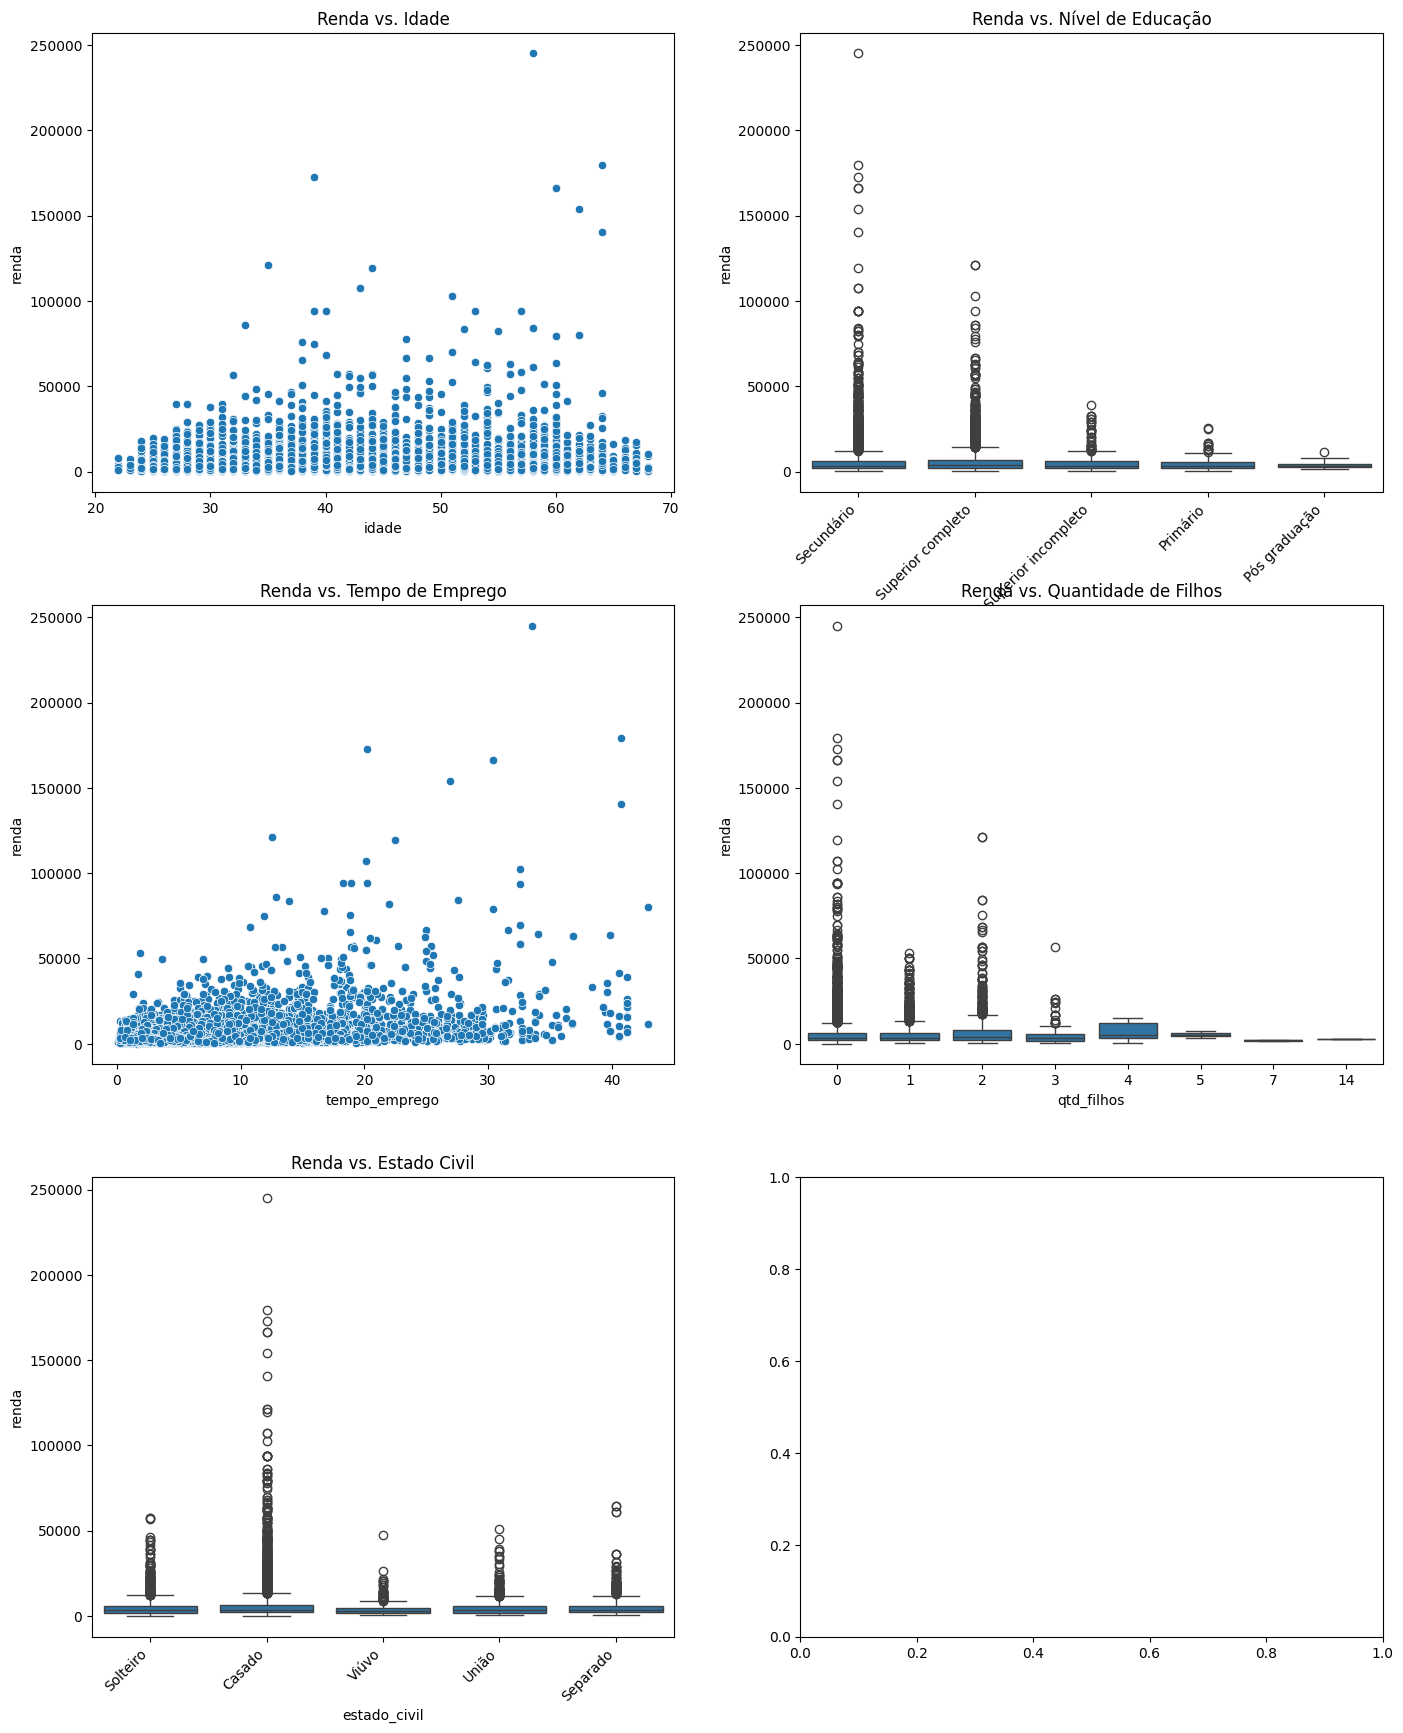

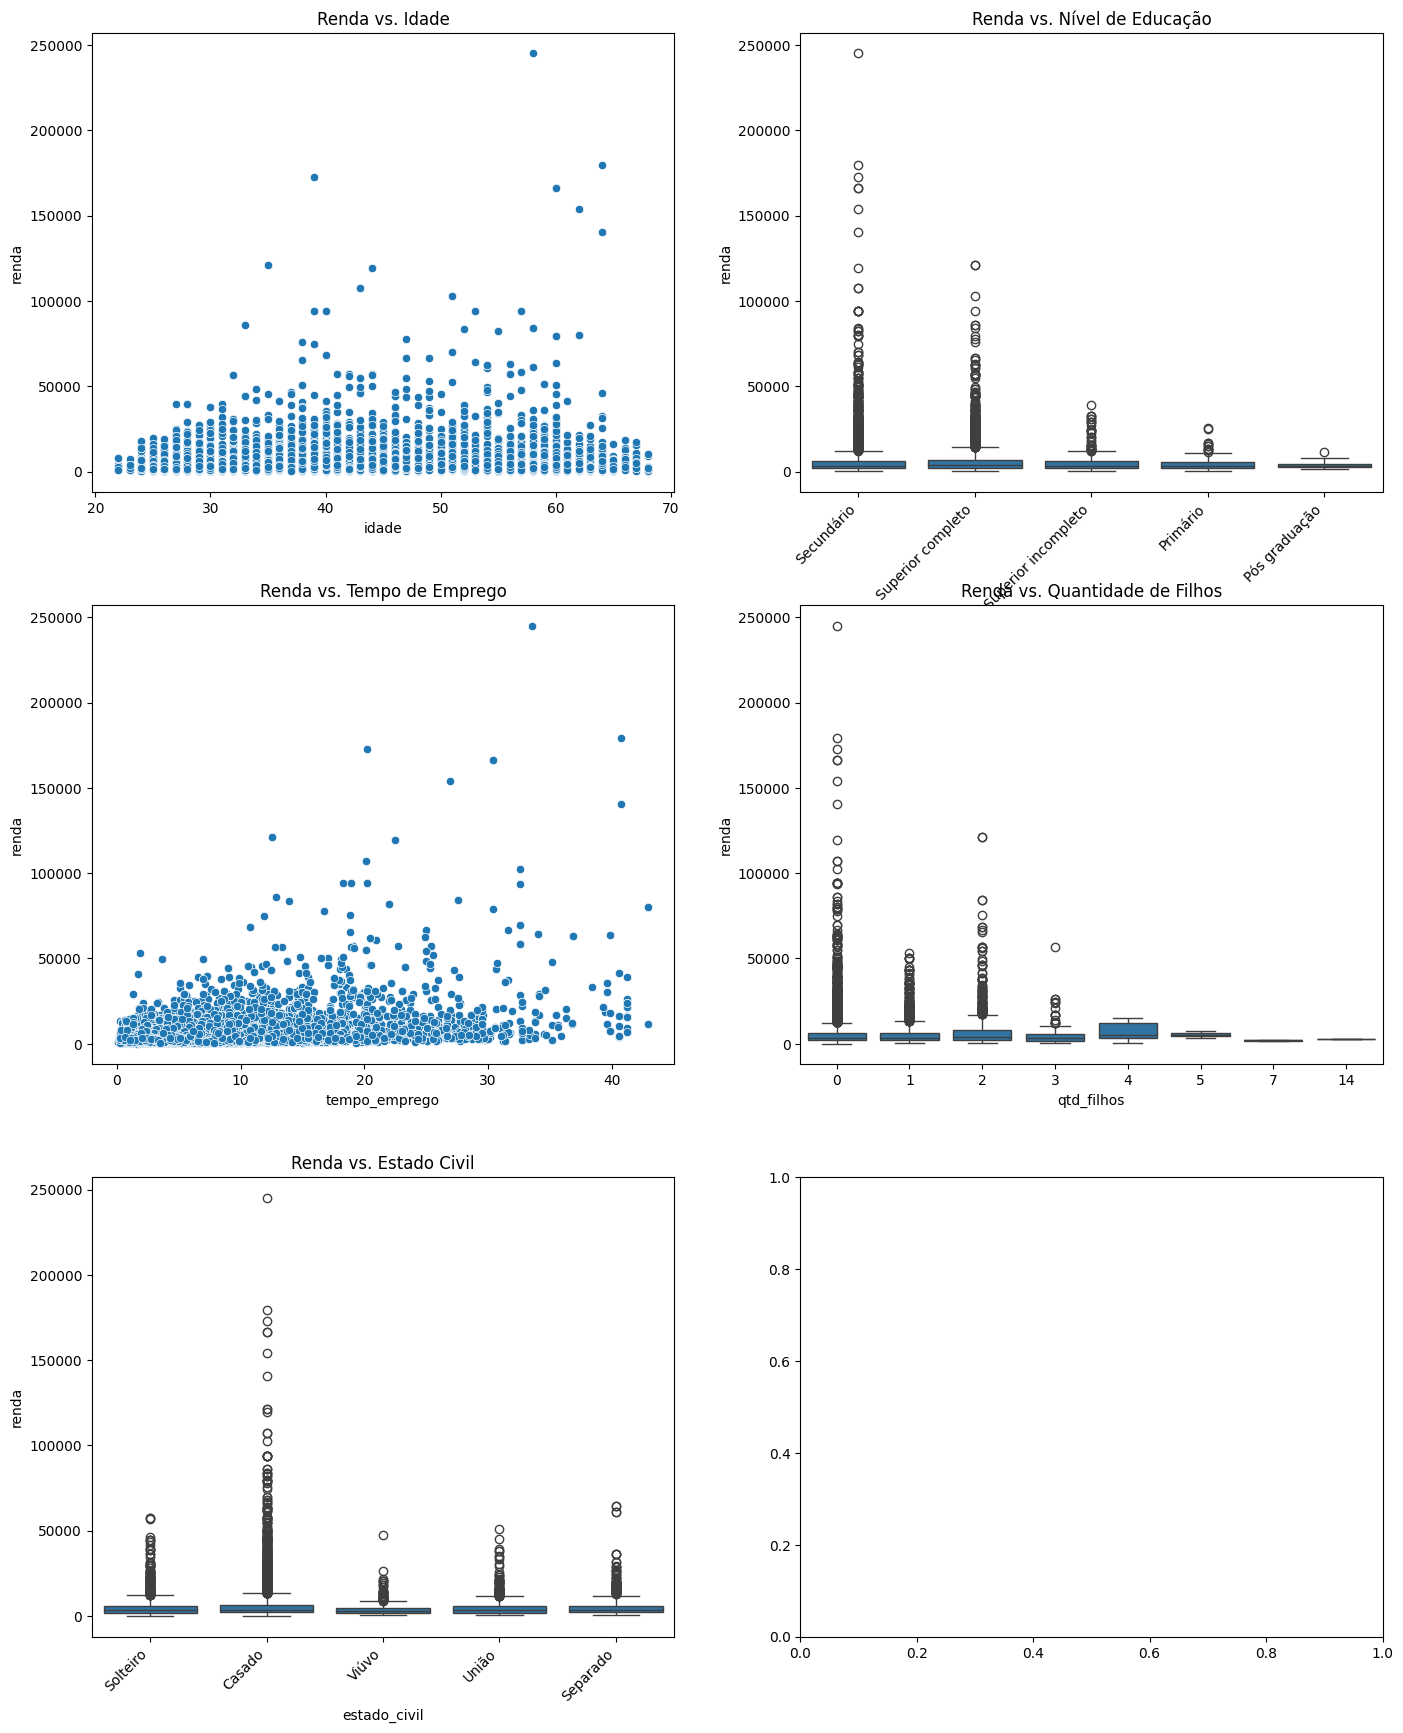

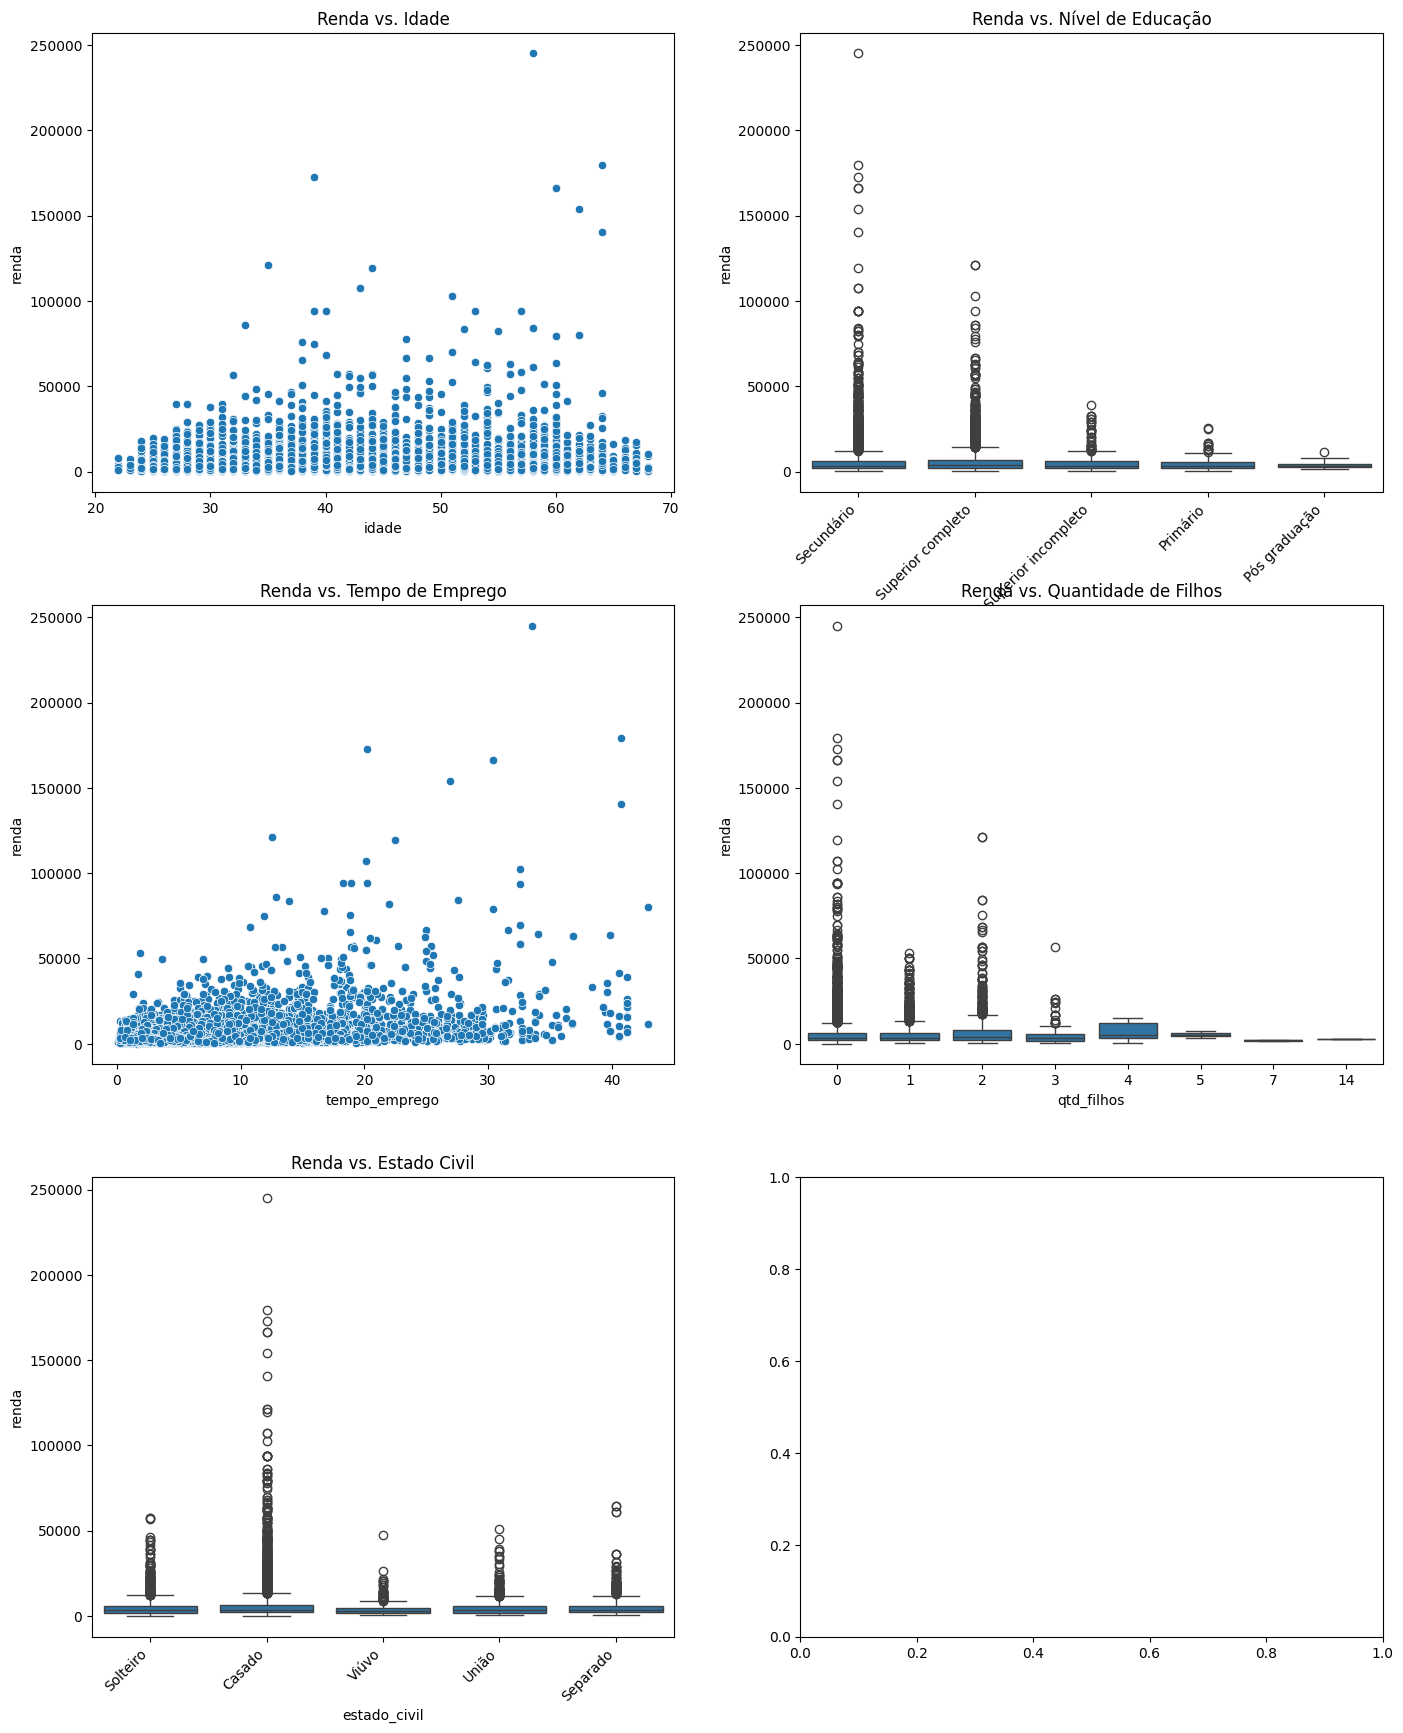

In [9]:
# Ativar a exibição de gráficos no notebook
%matplotlib inline
# Criar uma função para plotar e exibir as relações bivariadas
def plot_bivariate_relationships(renda):
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    plt.tight_layout(pad=6.0)

    # Renda vs. Idade
    sns.scatterplot(ax=axes[0, 0], data=renda, x='idade', y='renda')
    axes[0, 0].set_title('Renda vs. Idade')
    
    # Renda vs. Nível de Educação
    sns.boxplot(ax=axes[0, 1], data=renda, x='educacao', y='renda')
    axes[0, 1].set_title('Renda vs. Nível de Educação')
    axes[0, 1].set_xticks(range(len(renda['educacao'].unique())))
    axes[0, 1].set_xticklabels(renda['educacao'].unique(), rotation=45, horizontalalignment='right')
    
    # Renda vs. Tempo de Emprego
    sns.scatterplot(ax=axes[1, 0], data=renda, x='tempo_emprego', y='renda')
    axes[1, 0].set_title('Renda vs. Tempo de Emprego')
    
    # Renda vs. Quantidade de Filhos
    sns.boxplot(ax=axes[1, 1], data=renda, x='qtd_filhos', y='renda')
    axes[1, 1].set_title('Renda vs. Quantidade de Filhos')
    
    # Renda vs. Estado Civil
    sns.boxplot(ax=axes[2, 0], data=renda, x='estado_civil', y='renda')
    axes[2, 0].set_title('Renda vs. Estado Civil')
    axes[2, 0].set_xticks(range(len(renda['estado_civil'].unique())))
    axes[2, 0].set_xticklabels(renda['estado_civil'].unique(), rotation=45, horizontalalignment='right')

    plt.show()

# Plotar as relações bivariadas
plot_bivariate_relationships(renda)


O entendimento inicial dos dados de renda revela que a maioria dos indivíduos do conjunto de dados são mulheres, casadas, com ensino secundário completo, e vivendo em casas próprias. A análise univariada mostra que a idade média é de 43,88 anos, e a maioria das pessoas não possui filhos. Em termos de emprego, a média de tempo de trabalho é de aproximadamente 7,72 anos. A renda média dos indivíduos é de R$ 5697,29, com uma distribuição ampla que varia significativamente. As análises bivariadas indicam que níveis mais altos de educação e maior tempo de emprego estão positivamente correlacionados com rendas mais altas.

## Etapa 3 Crisp-DM: Preparação dos dados
Nessa etapa realizamos tipicamente as seguintes operações com os dados:

 - **seleção**: Já temos os dados selecionados adequadamente?
 - **limpeza**: Precisaremos identificar e tratar dados faltantes
 - **construção**: construção de novas variáveis
 - **integração**: Temos apenas uma fonte de dados, não é necessário integração
 - **formatação**: Os dados já se encontram em formatos úteis?



In [10]:
 renda = renda.drop(['Unnamed: 0', 'data_ref', 'id_cliente'], axis=1)

In [11]:
renda.isnull().sum()

sexo                        0
posse_de_veiculo            0
posse_de_imovel             0
qtd_filhos                  0
tipo_renda                  0
educacao                    0
estado_civil                0
tipo_residencia             0
idade                       0
tempo_emprego            2573
qt_pessoas_residencia       0
renda                       0
dtype: int64

In [12]:
renda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sexo                   15000 non-null  object 
 1   posse_de_veiculo       15000 non-null  bool   
 2   posse_de_imovel        15000 non-null  bool   
 3   qtd_filhos             15000 non-null  int64  
 4   tipo_renda             15000 non-null  object 
 5   educacao               15000 non-null  object 
 6   estado_civil           15000 non-null  object 
 7   tipo_residencia        15000 non-null  object 
 8   idade                  15000 non-null  int64  
 9   tempo_emprego          12427 non-null  float64
 10  qt_pessoas_residencia  15000 non-null  float64
 11  renda                  15000 non-null  float64
dtypes: bool(2), float64(3), int64(2), object(5)
memory usage: 1.2+ MB


In [13]:
# Tirando duplicados
renda = renda.drop_duplicates()
renda = renda.reset_index(drop=True)
print(renda.shape)
print("")
print(renda.info())

(10447, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10447 entries, 0 to 10446
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sexo                   10447 non-null  object 
 1   posse_de_veiculo       10447 non-null  bool   
 2   posse_de_imovel        10447 non-null  bool   
 3   qtd_filhos             10447 non-null  int64  
 4   tipo_renda             10447 non-null  object 
 5   educacao               10447 non-null  object 
 6   estado_civil           10447 non-null  object 
 7   tipo_residencia        10447 non-null  object 
 8   idade                  10447 non-null  int64  
 9   tempo_emprego          8655 non-null   float64
 10  qt_pessoas_residencia  10447 non-null  float64
 11  renda                  10447 non-null  float64
dtypes: bool(2), float64(3), int64(2), object(5)
memory usage: 836.7+ KB
None


In [15]:
# Limpeza: Identificar e tratar dados faltantes
# Remover linhas onde 'tempo_emprego' está ausente
renda = renda.dropna(subset=['tempo_emprego'])

# Preencher valores faltantes em 'tempo_emprego' com a média
renda['tempo_emprego'] = renda['tempo_emprego'].fillna(renda['tempo_emprego'].mean())

In [16]:
renda['renda_per_capita'] = renda['renda'] / renda['qt_pessoas_residencia']

In [18]:
renda['posse_de_veiculo'] = renda['posse_de_veiculo'].astype(bool)
renda['posse_de_imovel'] = renda['posse_de_imovel'].astype(bool)

In [19]:
renda.head()

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,renda_per_capita
0,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34,8060.340000
1,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15,926.075000
2,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,2253.89,1126.945000
3,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,4.846575,3.0,6600.77,2200.256667
4,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1.0,6475.97,6475.970000


Na Etapa 3 do Crisp-DM, focamos na preparação dos dados. Selecionamos os dados adequadamente e identificamos valores faltantes, tratando-os conforme necessário. Construímos novas variáveis úteis, como a renda per capita. Não foi necessário integrar dados de outras fontes, pois trabalhamos com um único dataset. Por fim, garantimos que os dados estivessem formatados corretamente para análise subsequente.


## Etapa 4 Crisp-DM: Modelagem
Nessa etapa que realizaremos a construção do modelo. Os passos típicos são:
- Selecionar a técnica de modelagem
- Desenho do teste
- Avaliação do modelo


### Rodando o modelo


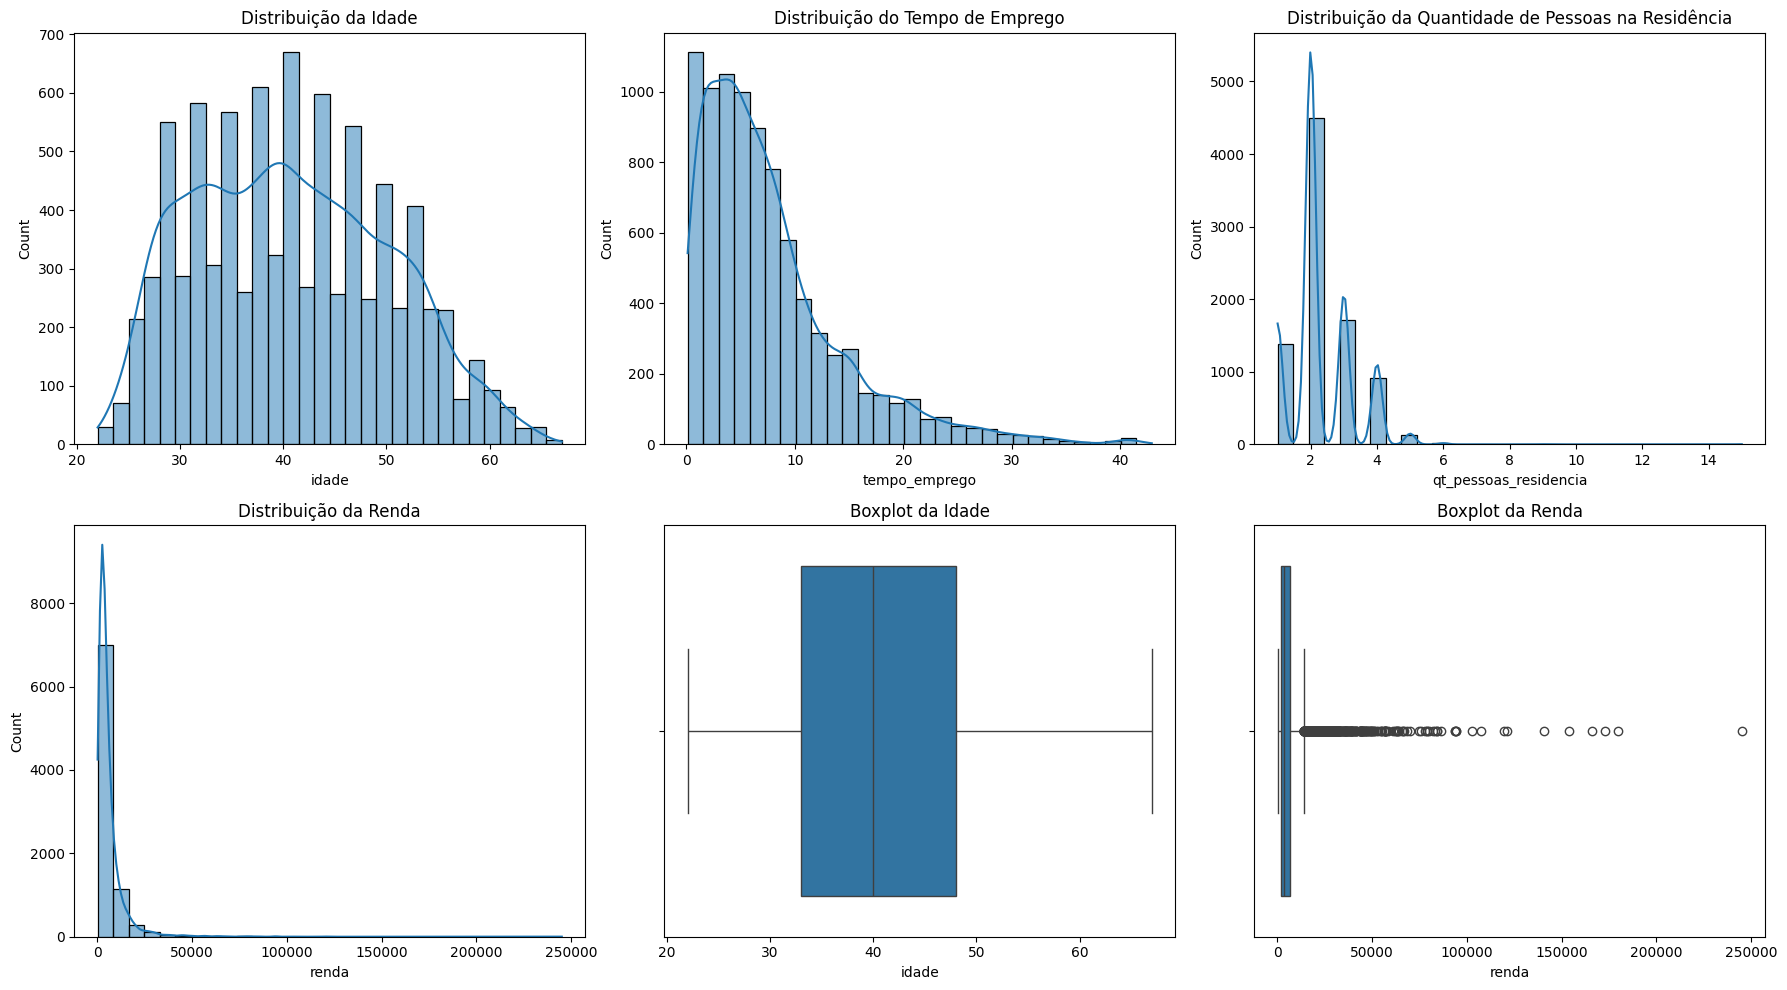

In [25]:
# Visualizar a distribuição das variáveis
def plot_variable_distributions(renda):
    plt.figure(figsize=(18, 10))

    # Distribuição da idade
    plt.subplot(2, 3, 1)
    sns.histplot(renda['idade'], kde=True, bins=30)
    plt.title('Distribuição da Idade')

    # Distribuição do tempo de emprego
    plt.subplot(2, 3, 2)
    sns.histplot(renda['tempo_emprego'], kde=True, bins=30)
    plt.title('Distribuição do Tempo de Emprego')

    # Distribuição da quantidade de pessoas na residência
    plt.subplot(2, 3, 3)
    sns.histplot(renda['qt_pessoas_residencia'], kde=True, bins=30)
    plt.title('Distribuição da Quantidade de Pessoas na Residência')

    # Distribuição da renda
    plt.subplot(2, 3, 4)
    sns.histplot(renda['renda'], kde=True, bins=30)
    plt.title('Distribuição da Renda')

    # Boxplot da idade
    plt.subplot(2, 3, 5)
    sns.boxplot(x=renda['idade'])
    plt.title('Boxplot da Idade')

    # Boxplot da renda
    plt.subplot(2, 3, 6)
    sns.boxplot(x=renda['renda'])
    plt.title('Boxplot da Renda')

    plt.tight_layout()
    plt.show()
    
    
# Seleção das variáveis para visualizar a distribuição
features = ['idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

# Verificar a presença de valores faltantes nas variáveis selecionadas
renda = renda.dropna(subset=features)

# Plotar a distribuição das variáveis
plot_variable_distributions(renda)


In [23]:
# Seleção das variáveis para o modelo
features = ['idade', 'tempo_emprego', 'qt_pessoas_residencia']
target = 'renda'

# Verificar a presença de valores faltantes nas variáveis selecionadas
renda = renda.dropna(subset=features + [target])

# Dividir os dados em conjuntos de treino e teste
X = renda[features]
y = renda[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Selecionar a técnica de modelagem: Regressão Linear
model = LinearRegression()

# Treinar o modelo
model.fit(X_train, y_train)

# Fazer previsões
y_pred = model.predict(X_test)

# Avaliação do modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

# Exibir coeficientes do modelo
coef_df = pd.DataFrame(model.coef_, features, columns=['Coeficiente'])
print(coef_df)

Mean Squared Error: 60624077.65494911
R² Score: 0.16999603863624402
                       Coeficiente
idade                    11.539343
tempo_emprego           491.947251
qt_pessoas_residencia   490.067056


In [30]:
features = ['idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

renda = renda.dropna(subset=features)


categorical_features = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']

# Separate features and target
X = renda.drop(columns='renda')
y = renda['renda']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ],
    remainder='passthrough'  
)


pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])


pipeline.fit(X_train, y_train)


y_pred = pipeline.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

evaluation_results = {
    'Model with Dummies': {'MSE': mse, 'MAE': mae, 'R2': r2},
 }

print(evaluation_results)

{'Model with Dummies': {'MSE': 9120607.712378962, 'MAE': 1461.6231085610782, 'R2': 0.8751298028086145}}


## Etapa 5 Crisp-DM: Avaliação dos resultados


Na Etapa 5 do Crisp-DM, focamos na construção do modelo e avaliação dele. Selecionamos a técnica de Regressão Linear para prever a renda com base em variáveis como idade, tempo de emprego e número de pessoas na residência. Dividimos os dados em conjuntos de treino e teste, treinamos o modelo e realizamos previsões. A avaliação do modelo foi feita através do Mean Squared Error (MSE) e do R² Score, que indicam a precisão das previsões.
O Modelo com Dummies apresentou um desempenho melhor em comparação ao Modelo sem Dummies. Isso é evidenciado por valores mais baixos de MSE e MAE, e um valor mais alto de R².
A inclusão de variáveis categóricas transformadas em dummies contribuiu para melhorar a capacidade preditiva do modelo, refletindo um ajuste melhor aos dados.

## Etapa 6 Crisp-DM: Implantação
Nessa etapa colocamos em uso o modelo desenvolvido, normalmente implementando o modelo desenvolvido em um motor que toma as decisões com algum nível de automação.